# Exploring the Relationship and Impact of Spatial Social Inequality on Childhood Obesity Prevalence in London

## Preparation

- [Github link](https://github.com/YUJIA-MA-UCL/Casa0006_YujiaMA.git) 

- Number of words: 1497

- Runtime: 0.6 minutes (*Hardware: 16.0GB RAM, 4.06GHz CPU (psutil-detected) OS: Darwin 24.4.0*)

- Coding environment: Local Python 3.9.6 environment (macOS 15.4 ARM processor)

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **libpysal**: Core library of the PySAL project used for spatial weights and spatial econometrics.
    - **spopt**: Spatial optimization library used for region-building algorithms such as SKATER.
    - **rfpimp**: A utility for calculating and plotting permutation-based feature importance for tree-based models.


## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Child obesity has become one of the global public health challenges (World Health Organization, 2018). According to the report released by the Office for Health Improvement & Disparities, from 2023 to 2024, 24% of children in Year 6 were considered obese in London. As Gupta et al. (2012) observe, the diseases caused by childhood obesity might cause psychosocial consequences like discrimination, social stigmatization, and bullying, which experiences not only diminish children’s immediate quality of life but also exacerbate existing social inequalities. 

There are strong links between socioeconomic status(SES) with childhood obesity, indicators like household income and parental education, influence children’s diet habits. White, Rehkopf & Mortensen (2016) found that children in England showed significant social inequalities in obesity prevalence, with children in low SES being more likely to be obese. Zhou, Harris & Tranos (2023) found that not only do traditional SES variables play a significant role in obesity risk in the UK, but also living location influences greatly in obesity prevalence, so the interaction between spatial factors and socioeconomic status cannot be ignored. Using spatial autocorrelation and clustering methods, Sun et al. (2020) reveal a significant geographical clustering of childhood obesity prevalence in different regions in England, which are often closely related to factors such as SES, educational resources, and the quality of public services within the region. 

Although research on childhood obesity prevalences in the UK now addresses socioeconomic inequalities, not much consideration has been given to their spatial dependence. London, as a representative metropolis with large internal disparities and significant socio-spatial inequalities, examining the clustering of childhood obesity rates and socio-economic characteristics in the London region could help us to better understand regional child health and target child health interventions.

In [1]:
# for recording runtime
import time
import psutil
import platform
import subprocess

start_time = time.time()

In [2]:
#!pip install libpysal spopt rfpimp

In [2]:
# for running the analysis 
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn import metrics
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

# Linear regression
from sklearn.linear_model import LinearRegression

# CART
from sklearn.tree import DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# feature importance
import rfpimp

# Skater clustering
from spopt.region import Skater

## Research questions

[[ go back to the top ]](#Table-of-contents)

1.	Is the association between childhood obesity and socioeconomic and social environmental factors primarily linear, or do non-linear models capture further nuances?
2.	How do spatial clusters of ward-level childhood obesity and key socioeconomic factors manifest in London, and what do they reveal about regional social inequalities affecting childhood health? 

## Data

[[ go back to the top ]](#Table-of-contents)

The Year 6 childhood obesity prevalence data (2010/11–2012/13) at the ward level (**Figure 1**) is used as the dependent variable. This period provides consistent data based on pre-2014 ward boundaries, ensuring uniform standards. Additionally, ward-level statistics are representative given children's limited activity ranges. It is also notable that in the NCMP dataset, wards with ≤5 obese children have suppressed values (recorded as zero).

Nine selected ward-level socioeconomic and social environmental factors (**Table 1**) were selected from various official sources such as Census 2011; Department for Education; Greenspace Information for Greater London. They are associated with household income, family status, parental education, lifestyle habits, resources accessibility and public security, which in turn affects childhood obesity prevalence (Cutler & Lleras-Muney, 2010; Goisis, Sacker & Kelly, 2016; Wang & Lim, 2012).

__<center> Table 1 Variable Selection and Description </center>__

| Variable                            | Type         | Description                                         |
|-------------------------------------|--------------|-------------------------------------------------------------------------|
| Year 6 (age 10-11) child obesity prevalence (%) | Numeric| The year 6 (age 10-11) children’s obesity prevalence for wards. Used as dependent variable in regression. |
| Children in poverty rate (%) | Numeric| The percentages of children in poverty for wards. |
| Median household income | Numeric| The median of household income for wards. |
| Unemployed rate (%) | Numeric|The percentage of unemployed people for wards. |
| Qualifications – Level 4 and above rate (%) | Numeric| The percentage of people with Level 4 and above level qualifications for wards. |
| Average GCSE score | Numeric| The student’s average GCSE score for wards. |
| Unauthorised absence in all schools rate (%) | Numeric| The percentage of pupils absent unauthorisedly in all schools for wards. |
| Crime rate (%) | Numeric| The total crime rate for wards. |
|People with bad or very bad health rate (%) | Numeric| The percentage of people with bad or very bad health for wards.|
|Households with access to open space (%) | Numeric| The percentage of households with access to open space for wards. |

In [4]:
# load in the dataset
obesity_ward = pd.read_csv('https://github.com/YUJIA-MA-UCL/Casa0006_childhood_obesity/raw/refs/heads/main/data.csv')
obesity_ward.info()

# The prevalence of childhood obesity that is less than 5 is 
# being suppressed, so there are some 'na' value in 
# 'Childhood_Obesity_Year6' column
obesity_ward_clean = obesity_ward.dropna()
obesity_ward_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ward_code                            625 non-null    object 
 1   Ward                                 625 non-null    object 
 2   Borough                              625 non-null    object 
 3   Childhood_Obesity_Year6              613 non-null    float64
 4   Children_in_poverty                  625 non-null    float64
 5   Crime_rate                           625 non-null    float64
 6   Unauthorised_Absence_in_All_Schools  625 non-null    float64
 7   Median_Household_income              625 non-null    int64  
 8   Qualifications_Level4_and_above      625 non-null    float64
 9   Households_with_access_to_openspace  625 non-null    float64
 10  People_with_Bad_or_Very_Bad_Health   625 non-null    float64
 11  Average_GCSE                    

In [5]:
# download the shapefile and read in
import requests
import zipfile
import io
url = "https://github.com/YUJIA-MA-UCL/Casa0006_childhood_obesity/raw/refs/heads/main/statistical-gis-boundaries-london.zip"
response = requests.get(url)
# unzip the package
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("Ward_boundary_shapefile")

# load in the boudary shapefile data
gdf = gpd.read_file("statistical-gis-boundaries-london/London_Ward_CityMerged.shp")

# merge the data with gdf
gdf_obesity = pd.merge(gdf,obesity_ward_clean,
                       left_on='GSS_CODE', 
                       right_on='ward_code', 
                       how='left')
gdf_obesity.info()

gdf_obesity_clean = gdf_obesity.dropna()
gdf_obesity_clean.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   NAME                                 625 non-null    object  
 1   GSS_CODE                             625 non-null    object  
 2   HECTARES                             625 non-null    float64 
 3   NONLD_AREA                           625 non-null    float64 
 4   LB_GSS_CD                            625 non-null    object  
 5   BOROUGH                              625 non-null    object  
 6   POLY_ID                              625 non-null    int64   
 7   geometry                             625 non-null    geometry
 8   ward_code                            613 non-null    object  
 9   Ward                                 613 non-null    object  
 10  Borough                              613 non-null    object  
 11  Childhood_O

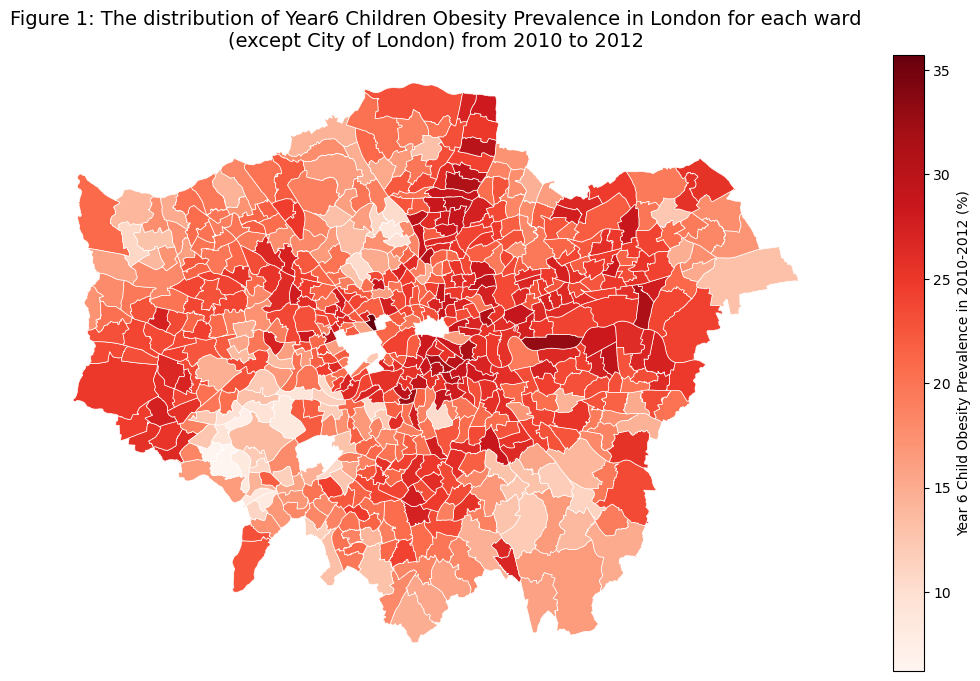

In [6]:
# define a function to plot the obesity distribution map
def obesityPlot():
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    gdf_obesity_clean.plot(edgecolor=(1, 1, 1, 1),linewidth=0.5, 
                           column='Childhood_Obesity_Year6',
                           cmap='Reds',
                           legend=True,
                           legend_kwds={'label': "Year 6 Child Obesity Prevalence in 2010-2012 (%)"},
                           ax=ax)
    
    ax.set_title("Figure 1: The distribution of Year6 Children Obesity Prevalence in London for each ward\n(except City of London) from 2010 to 2012", fontsize=14)
    ax.axis('off')
    #plt.savefig("obesity_map.jpg", dpi=300, bbox_inches='tight')
    plt.show()
   
obesityPlot()

In [7]:
# subset the obesity_ward with only numeric variables to prepare 
# for data handling, as ML models can't deal with strings
df = obesity_ward_clean[['Childhood_Obesity_Year6',
                   'Children_in_poverty', 
                   'Median_Household_income',
                   'Unemployed',
                   'Qualifications_Level4_and_above',
                   'Average_GCSE', 
                   'Unauthorised_Absence_in_All_Schools', 
                   'Crime_rate', 
                   'People_with_Bad_or_Very_Bad_Health',
                   'Households_with_access_to_openspace']]

**Figure 2** and the table below show histograms and descriptive statistics for the selected variables, and it can be learnt that: there are differences in the scale of the variables; and “Crime_rate”, “Median_household_income” and “Unemployed” are skewed. So, log transformation and z-score standardisation can be used here to reduce the impact of different scales and skewed distributions on the results. 

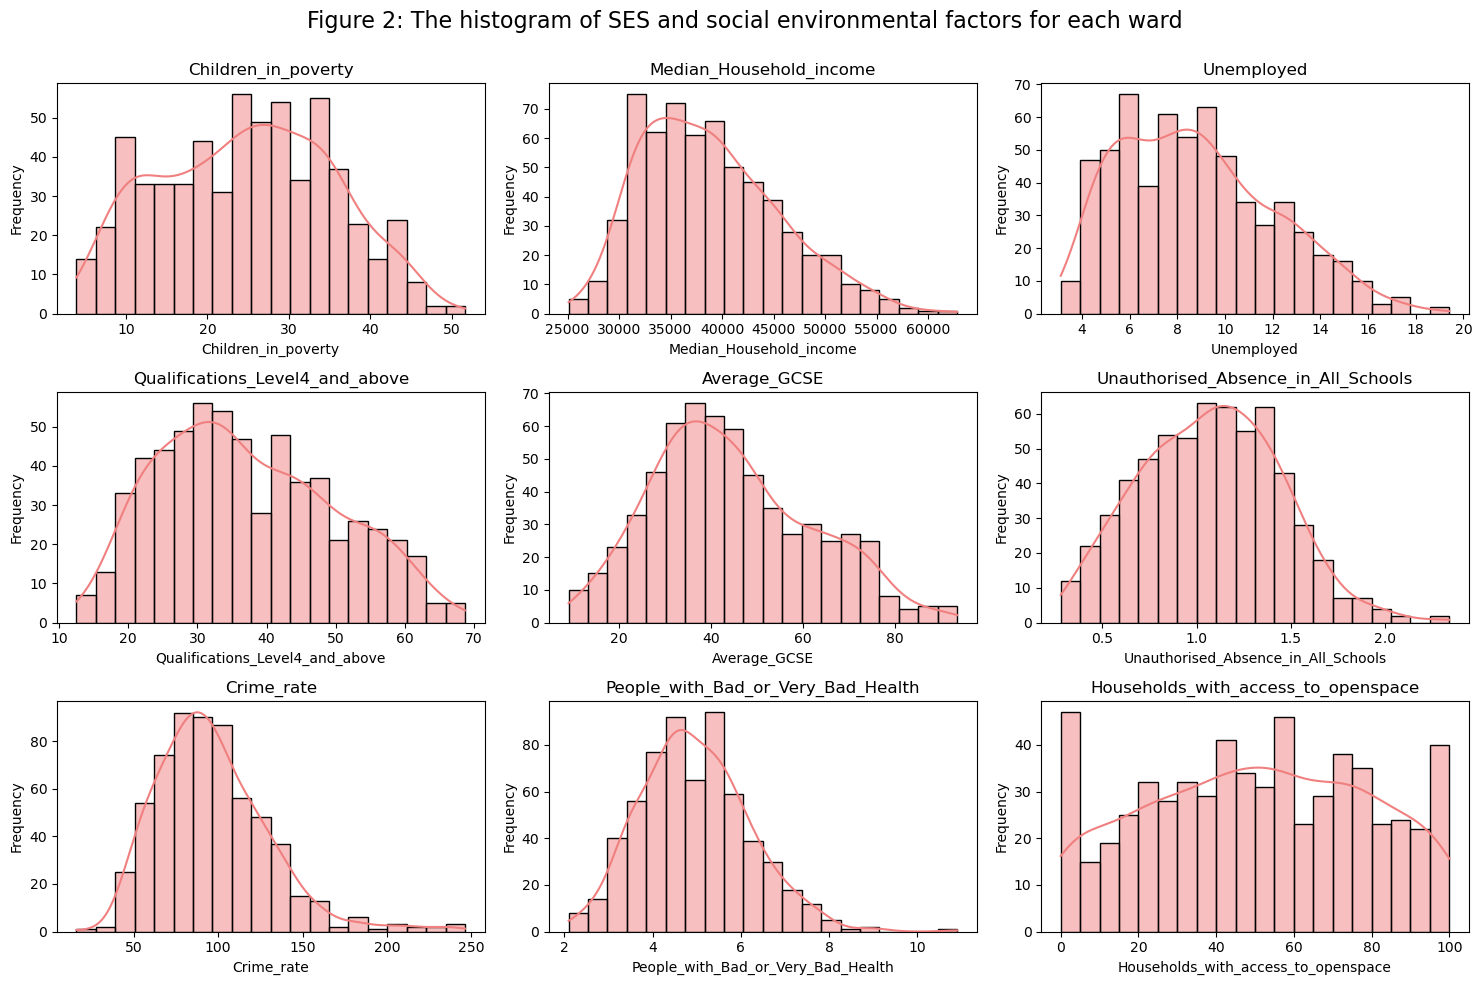

                                     count       mean       std        min  \
Childhood_Obesity_Year6              613.0     21.539     5.062      6.220   
Children_in_poverty                  613.0     24.808    10.540      3.900   
Median_Household_income              613.0  38808.630  6657.753  25090.000   
Unemployed                           613.0      8.812     3.247      3.115   
Qualifications_Level4_and_above      613.0     37.217    12.570     12.500   
Average_GCSE                         613.0     44.557    17.302      9.077   
Unauthorised_Absence_in_All_Schools  613.0      1.074     0.370      0.280   
Crime_rate                           613.0     96.599    33.500     15.950   
People_with_Bad_or_Very_Bad_Health   613.0      4.966     1.232      2.100   
Households_with_access_to_openspace  613.0     50.494    28.569      0.000   

                                           25%        50%        75%  \
Childhood_Obesity_Year6                 18.500     22.220     25.380 

In [8]:
# descriptive analysis
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()
variables = df.columns[1:10]
# Histgram of each variable
for i, var in enumerate(variables):
    sns.histplot(df[var].dropna(), bins=20, 
                 kde=True, ax=axes[i], color='lightcoral')
    axes[i].set_title(var)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Frequency")
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Figure 2: The histogram of SES and social environmental factors for each ward", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# generate summary statistics for the DataFrame
# the result is transposed so that variables are shown as rows
summary = df.describe().T
# the skewness of each variable (measure of asymmetry)
summary['Skewness'] = df.skew()
# the kurtosis of each variable (measure of tail heaviness)
summary['Kurtosis'] = df.kurtosis()
print(summary.round(3))

In [33]:
# do the log-transformation on the data 
# and add the transformed data columns to the df
df['Median_Household_income_log']= np.log1p(df['Median_Household_income'])
df['Crime_rate_log']= np.log1p(df['Crime_rate'])
df['Unemployed_log']= np.log1p(df['Unemployed'])

# subset the dataframe with transformed data
df1 = df[['Childhood_Obesity_Year6',
         'Children_in_poverty', 
         'Median_Household_income_log',
         'Unemployed_log',
         'Qualifications_Level4_and_above',
         'Average_GCSE', 
         'Unauthorised_Absence_in_All_Schools', 
         'Crime_rate_log', 
         'People_with_Bad_or_Very_Bad_Health',
         'Households_with_access_to_openspace']]

# do the z-score normalisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df2 = scaler.fit_transform(df1)

df2 = pd.DataFrame(df2, columns=df1.columns)

After data handling, all variables tend to be normally distributed and are in similar ranges (**Figure 3**).

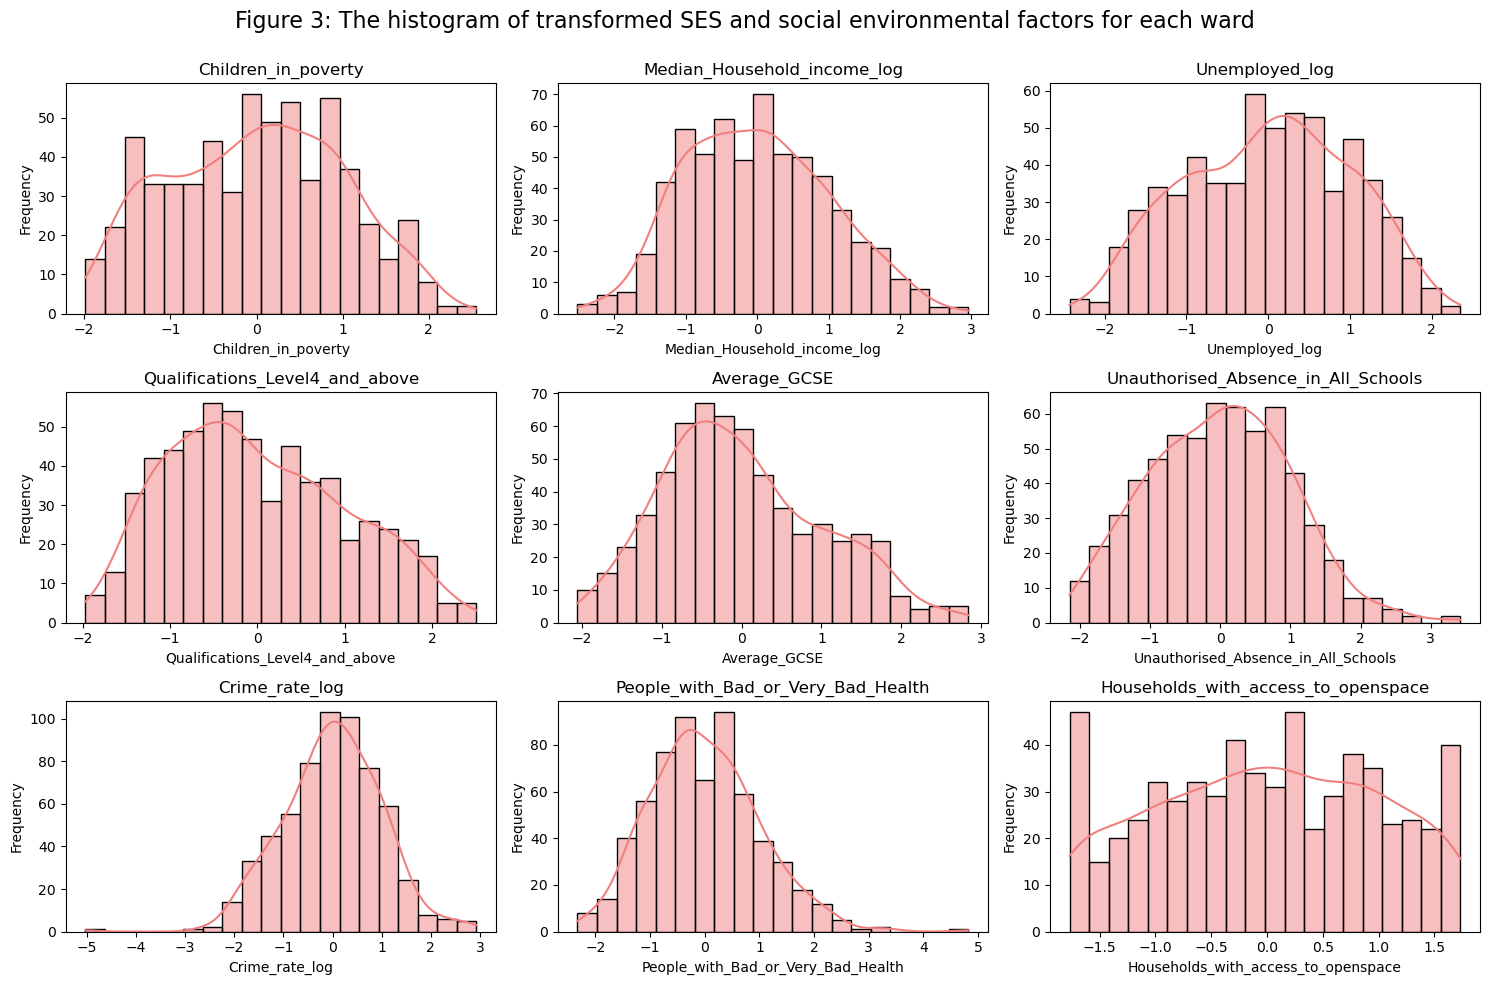

                                     count  mean    std    min    25%    50%  \
Childhood_Obesity_Year6              613.0   0.0  1.001 -3.029 -0.601  0.135   
Children_in_poverty                  613.0  -0.0  1.001 -1.985 -0.820  0.025   
Median_Household_income_log          613.0  -0.0  1.001 -2.516 -0.780 -0.027   
Unemployed_log                       613.0   0.0  1.001 -2.431 -0.803  0.083   
Qualifications_Level4_and_above      613.0  -0.0  1.001 -1.968 -0.798 -0.161   
Average_GCSE                         613.0   0.0  1.001 -2.052 -0.735 -0.139   
Unauthorised_Absence_in_All_Schools  613.0  -0.0  1.001 -2.146 -0.741  0.016   
Crime_rate_log                       613.0   0.0  1.001 -5.023 -0.644 -0.002   
People_with_Bad_or_Very_Bad_Health   613.0  -0.0  1.001 -2.329 -0.703 -0.135   
Households_with_access_to_openspace  613.0   0.0  1.001 -1.769 -0.789  0.044   

                                       75%    max  Skewness  Kurtosis  
Childhood_Obesity_Year6              0.759  2.8

In [10]:
# show the new histogram and summary after data processing
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()
variables = df2.columns[1:10]
# Histgram of each variable
for i, var in enumerate(variables):
    sns.histplot(df2[var].dropna(), bins=20, kde=True, ax=axes[i], color='lightcoral')
    axes[i].set_title(var)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Frequency")
  
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Figure 3: The histogram of transformed SES and social environmental factors for each ward", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

newsummary = df2.describe().T
newsummary['Skewness'] = df2.skew()
newsummary['Kurtosis'] = df2.kurtosis()
print(newsummary.round(3))

# show the results of normalisation
print("\nThe range of data:")
for c in df2.columns.values:
    print("The range of {} is [{}, {}]".format(c, df2[c].min(), df2[c].max()))

**Figure 4** shows the relationship between childhood obesity prevalence and nine selected variables. Most of the scatterplots show a more linear positive or negative relationship. While some variables, like “Crime_rate_log”, implicitly show some trend — a more dispersed distribution of point clouds, suggesting that the association may be weaker or exhibit non-linearity. 

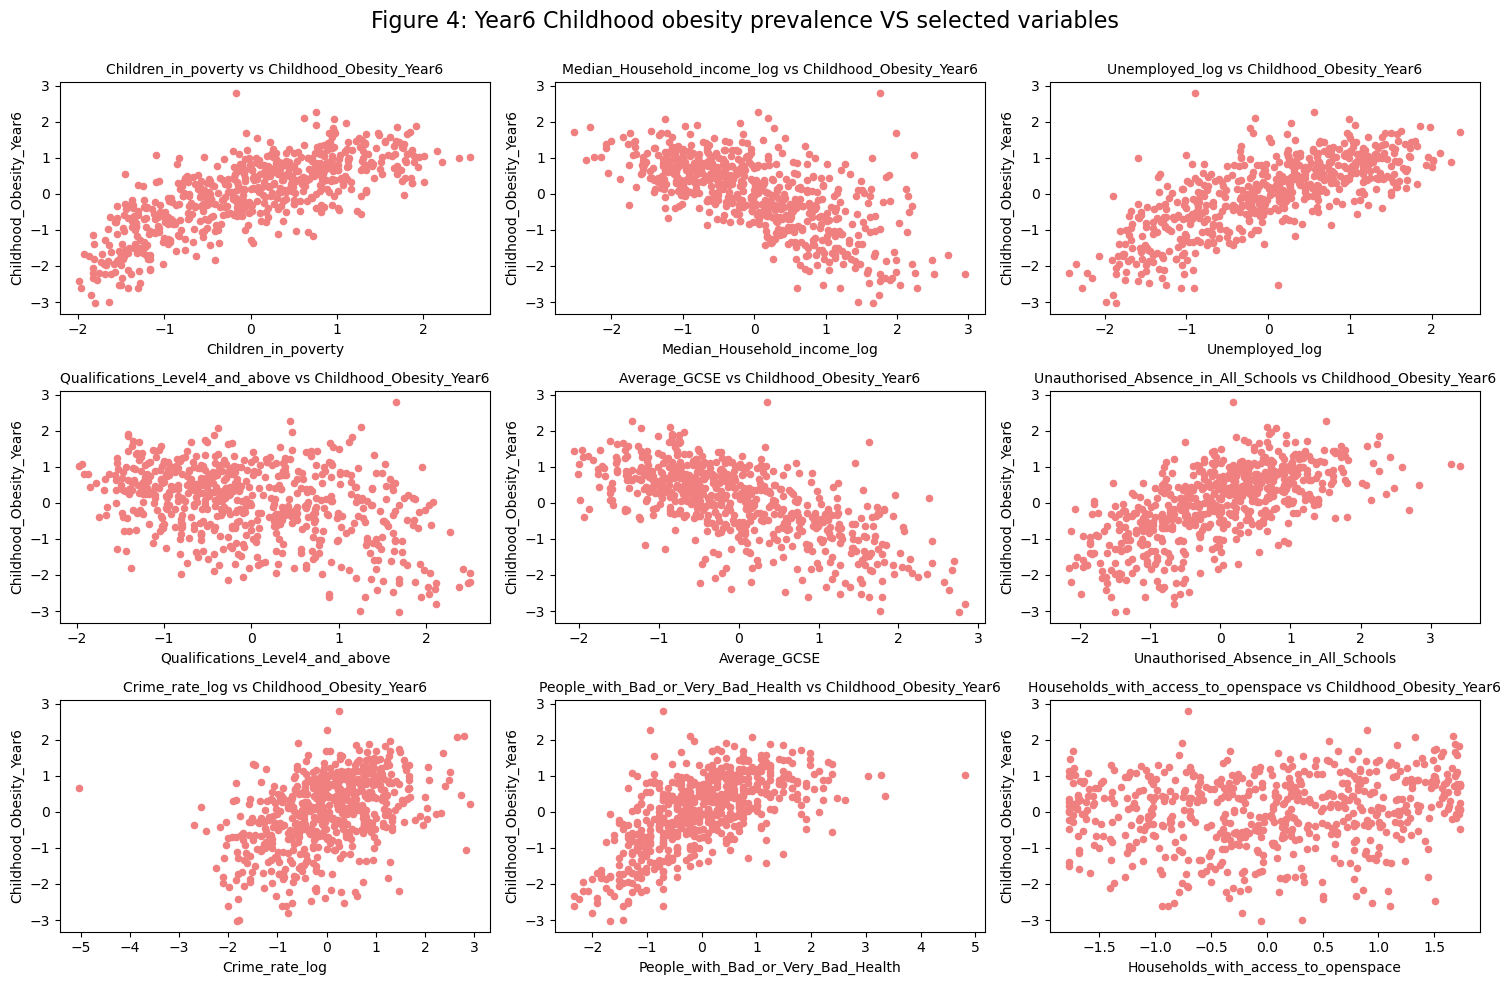

In [11]:
# show the scatterplots of 
# Year6 childhood obesity prevalences vs selected variables
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(df2.columns[1:10]):
    df2.plot.scatter(x=col, y='Childhood_Obesity_Year6', ax=axes[i], color = 'lightcoral')
    axes[i].set_title(f"{col} vs Childhood_Obesity_Year6", fontsize=10)
fig.suptitle("Figure 4: Year6 Childhood obesity prevalence VS selected variables", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Subsequently, we examined the variable correlations (**Figure 5**), which revealed potential multicollinearity. We calculated the Variance Inflation Factor for each predictor. Since no variable exceeded threshold of 10, all variables were retained for the regression analysis.

<Figure size 1500x1000 with 0 Axes>

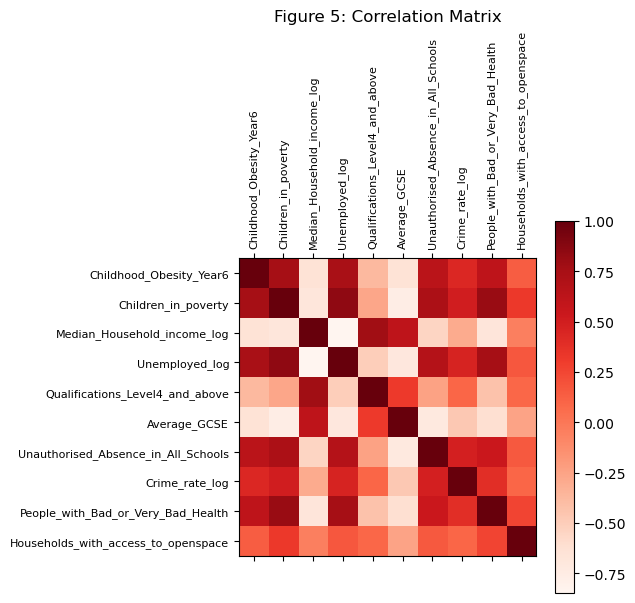

In [12]:
# define a correlation matrix calculation function
def CorrelationMatrix(df):
    corr_matrix = df.corr()
    #corr_matrix.to_csv("correlation_matrix.csv")
    
    f = plt.figure(figsize=(15, 10))
    plt.matshow(df.corr(), fignum=None, cmap='Reds')
    num_cols = corr_matrix.shape[1]
    plt.xticks(range(num_cols), corr_matrix.columns, fontsize=8, rotation=90)
    plt.yticks(range(num_cols), corr_matrix.columns, fontsize=8)
    plt.title('Figure 5: Correlation Matrix', fontsize=12)
    plt.colorbar()
    
    #plt.savefig("Correlation Matrix.jpg", dpi=300, bbox_inches='tight')
    plt.show()

# compute the correlation between nine variables
CorrelationMatrix(df2)

In [13]:
# define a VIF test function
def drop_column_using_vif_(df, thresh=5):
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)
        
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",index=df_with_const.columns).to_frame()
        
        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, 
        # remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, 
        # only one of them is removed. 
        # Because we want to keep as many variables as possible.
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF,
            # choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            print(vif_df.VIF.max())
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop.
            break
    return df.columns, vif_df

In [14]:
# calculate the VIF, and show the dataset columns 
# after dropping the variable with the VIF higher than 10
drop_column_using_vif_(df2.drop('Childhood_Obesity_Year6',axis=1), thresh=10)

(Index(['Children_in_poverty', 'Median_Household_income_log', 'Unemployed_log',
        'Qualifications_Level4_and_above', 'Average_GCSE',
        'Unauthorised_Absence_in_All_Schools', 'Crime_rate_log',
        'People_with_Bad_or_Very_Bad_Health',
        'Households_with_access_to_openspace'],
       dtype='object'),
                                           VIF
 Children_in_poverty                  8.071529
 Median_Household_income_log          9.774373
 Unemployed_log                       7.083408
 Qualifications_Level4_and_above      5.000526
 Average_GCSE                         2.960171
 Unauthorised_Absence_in_All_Schools  2.595122
 Crime_rate_log                       1.767667
 People_with_Bad_or_Very_Bad_Health   3.629832
 Households_with_access_to_openspace  1.232980)

Overall, we still have nine variables as the independent variable.

In [15]:
# final variables
X = df2[['Children_in_poverty', 'Median_Household_income_log', 'Unemployed_log',
       'Qualifications_Level4_and_above', 'Average_GCSE',
       'Unauthorised_Absence_in_All_Schools', 'Crime_rate_log',
       'People_with_Bad_or_Very_Bad_Health',
       'Households_with_access_to_openspace']]
y = df2['Childhood_Obesity_Year6']

## Methodology

[[ go back to the top ]](#Table-of-contents)
__<center> Figure 6: Methodology Flow Chart </center>__
    
![Flow chart](https://raw.githubusercontent.com/YUJIA-MA-UCL/Casa0006_childhood_obesity/refs/heads/main/pics/flow%20chart.jpg)

The Ordinary Least Squares (OLS) model is the baseline model to compare with two tree-based models: Classification and Regression Tree (CART) and Random Forest. The dataset is split according to a 75:25 split into training and test sets to ensure unbiased evaluation.  

The baseline model is specified as:
$$
Y = β_1X_1 + β_2X_2 + β_3X_3 + ... + β_9X_9 + β_0
$$

where $Y$ is the childhood obesity prevalence and $X_1$–$X_9$ are nine indicators. The OLS model estimates the linear relationships between these variables. CART and Random Forest will capture the potential non-linear effects. And hyperparameter tuning is conducted via K-fold cross-validation. 

We compare R², RMSE, and MAE across models on the same test set, to see which model shows the best performance, and the tree-based models also provide feature importance, which identifies the key factors driving childhood obesity. 

To evaluate spatial dependences, we compute Moran's I, which equals 0.51, indicating a significant spatial autocorrelation. Consequently, we use SKATER—a spatially constrained clustering algorithm—to partition London wards into coherent clusters. For clustering, we focus on the three most influential variables alongside obesity prevalence to reduce noise and enhance interpretability. This approach simplifies the model and yields robust, actionable insights into regional disparities in childhood obesity, thereby better informing targeted public health interventions.

In [16]:
train_x, test_x, train_y, test_y = train_test_split(
    X, y, random_state=100)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. 
# the index indicates which rows from the original data.
print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(459, 9)
(459,)
(154, 9)
(154,)
True
True


In [17]:
# constructing weight matrices using Queen neighbours
w = ps.weights.contiguity.Queen.from_dataframe(gdf_obesity_clean, use_index=False)
# normalisation of the weight matrix (row normalisation)
w.transform = 'r'

# calculate Moran's I value and the p-value
from esda import Moran
y = gdf_obesity_clean['Childhood_Obesity_Year6']
mi = Moran(y, w)

print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)

Moran's I: 0.5168189268424859
p-value: 0.001


## Results and discussion

[[ go back to the top ]](#Table-of-contents)

In [18]:
# build a OLS - linear regression model
lm = LinearRegression()
lm.fit(train_x, train_y)

LinearRegression()

In [19]:
# build a CART using default settings
cart_default = DecisionTreeRegressor(random_state=0)
cart_default.fit(train_x, train_y)
# print the tree depth
print("Tree depth: {}".format(cart_default.get_depth()))

Tree depth: 23


In [20]:
# 1. values of max_depth
# smaller values (e.g., 2, 3) help prevent overfitting 
# and encourage generalization
# larger values (e.g., 15, 20, 30) allow the model to capture 
# more complex patterns

# 2. values of min_samples_split
# smaller values (e.g., 2, 4) allow more frequent splitting and 
# may lead to overfitting
# larger values (e.g., 50, 80, 100) create more conservative splits 
# and may reduce model complexity

# This range allows testing both highly flexible and 
# more regularized models

hyperparameters = {'max_depth':[2,3,5,10,15,20,30], 
                   'min_samples_split':[2,4,6,8,10,20,50,80,100]}
randomState_dt = 10000
dt = DecisionTreeRegressor(random_state=randomState_dt)

# K-fold cross-validation to tuning the hyperparameters:
# cv=5 by default, which means 5-fold cross-validation
clf_dt = GridSearchCV(dt, hyperparameters)
clf_dt.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf_dt.best_params_)
print ("The best score is: ")
print (clf_dt.best_score_)

The best parameter value is: 
{'max_depth': 3, 'min_samples_split': 80}
The best score is: 
0.6302288007578204


In [21]:
# build a Decision Tree Regressor using the best hyperparameters
dt_final = DecisionTreeRegressor(
    max_depth = clf_dt.best_params_['max_depth'],
    min_samples_split = clf_dt.best_params_['min_samples_split'],
    random_state = randomState_dt)
# train the final Decision Tree model using the training data
dt_final.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=3, min_samples_split=80, random_state=10000)

In [22]:
# build a Random Forest using default settings
rf_default = RandomForestRegressor(random_state=0)
rf_default.fit(train_x, train_y)

# view the depth of all trees in a random forest
tree_depths = [estimator.get_depth() for estimator in rf_default.estimators_]

print("Number of trees:", len(tree_depths))
print("Average tree depth:", sum(tree_depths)/len(tree_depths))
print("Maximum tree depth:", max(tree_depths))
print("Minimum tree depth:", min(tree_depths))

Number of trees: 100
Average tree depth: 18.7
Maximum tree depth: 26
Minimum tree depth: 14


In [23]:
hyperparameters = {'max_depth':[2,3,5,10,15,20,30,40,50], 
                   'min_samples_split':[2,4,6,8,10,20,40,50]}

randomState_rf = 10000
rf = RandomForestRegressor(random_state=randomState_rf)

# K-fold cross-validation to tuning the hyperparameters:
# cv=5 by default, which means 5-fold cross-validation
clf_rf = GridSearchCV(rf, hyperparameters)
clf_rf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf_rf.best_params_)
print ("The best score is: ")
print (clf_rf.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 6}
The best score is: 
0.6439488031833459


In [24]:
# build a Random Forest Regressor using the best hyperparameters
rf_final = RandomForestRegressor(
    max_depth = clf_rf.best_params_['max_depth'], 
    min_samples_split = clf_rf.best_params_['min_samples_split'], 
    random_state = randomState_rf)
# train the final Random Forest model using the training data
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=10, min_samples_split=6, random_state=10000)

In [25]:
# create a dataframe for comparison
# evaluate the performance of the OLS (Linear Regression) model
ols_results = {
    'Training R²':lm.score(X=train_x, y=train_y),
    'Testing R²':lm.score(X=test_x, y=test_y),
    'Training RMSE':root_mean_squared_error(train_y, 
                                            lm.predict(train_x)),
    'Testing RMSE':root_mean_squared_error(test_y, 
                                           lm.predict(test_x)),
    'Training MAE':mean_absolute_error(train_y, 
                                       lm.predict(train_x)),
    'Testing MAE':mean_absolute_error(test_y, 
                                      lm.predict(test_x))
}
# evaluate the performance of the CART (Decision Tree Regressor) model
cart_results = {
    'Training R²': dt_final.score(X=train_x, y=train_y),
    'Testing R²': dt_final.score(X=test_x, y=test_y),
    'Training RMSE':root_mean_squared_error(train_y, 
                                            dt_final.predict(train_x)),
    'Testing RMSE': root_mean_squared_error(test_y, 
                                            dt_final.predict(test_x)),
    'Training MAE':mean_absolute_error(train_y, 
                                       dt_final.predict(train_x)),
    'Testing MAE': mean_absolute_error(test_y, 
                                       dt_final.predict(test_x))
}
# evaluate the performance of the Random Forest model
rf_results = {
    'Training R²': rf_final.score(X=train_x, y=train_y),
    'Testing R²': rf_final.score(X=test_x, y=test_y),
    'Training RMSE':root_mean_squared_error(train_y, 
                                            rf_final.predict(train_x)),
    'Testing RMSE': root_mean_squared_error(test_y, 
                                            rf_final.predict(test_x)),
    'Training MAE':mean_absolute_error(train_y, 
                                       rf_final.predict(train_x)),
    'Testing MAE': mean_absolute_error(test_y, 
                                       rf_final.predict(test_x))
}

# combine the results
compare_results = pd.DataFrame({
    'OLS': ols_results,
    'CART': cart_results,
    'Random Forest': rf_results
})
compare_results = compare_results.T

In [26]:
def compare_result(df_results):
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))

    # Plot R²
    df_results[['Training R²', 'Testing R²']].plot(kind='bar', ax=axes[0], rot=0, colormap='Set1')
    axes[0].set_title('Model R² Comparison')
    axes[0].set_ylabel('R² Score')

    # Plot RMSE
    df_results[['Training RMSE', 'Testing RMSE']].plot(kind='bar', ax=axes[1], rot=0, colormap='Set2')
    axes[1].set_title('Model RMSE Comparison')
    axes[1].set_ylabel('RMSE')

    # Plot MAE
    df_results[['Training MAE', 'Testing MAE']].plot(kind='bar', ax=axes[2], rot=0, colormap='Set3')
    axes[2].set_title('Model MAE Comparison')
    axes[2].set_ylabel('MAE')

    plt.suptitle("Figure 7: Model Performance Comparison", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    #plt.savefig("Model Performance Comparison.jpg", dpi=300, bbox_inches='tight')
    plt.show()
    return df_results

After building and training three models, we evaluate their performances: the OLS model yielded a training R² of 0.651 and a testing R² of 0.568, with RMSE values of 0.602 (training) and 0.613 (testing), and MAE values of 0.475 on both sets, indicating moderate linear predictive power and similar performance on both sets, confirming the linear relationships in the predictors.

In contrast, the CART model achieved a slightly higher training R² (0.677) but a lower testing R² (0.535), along with higher testing RMSE (0.636) and MAE (0.511), suggesting poorer generalizability.

The Random Forest model achieved an exceptionally high training R² of 0.917 with low training errors. Although the Random Forest shows overfitting, it successfully captures complex and nonlinear relationships to slightly improve test performance compared to OLS. 

In summary, the baseline OLS model exhibits robust and interpretable performance, while the Random Forest provides marginal improvements on unseen data. This suggests that although the relationship between socioeconomic factors and childhood obesity is predominantly linear, the ensemble approach captures subtle nuances that slightly enhance prediction in a complex urban context.


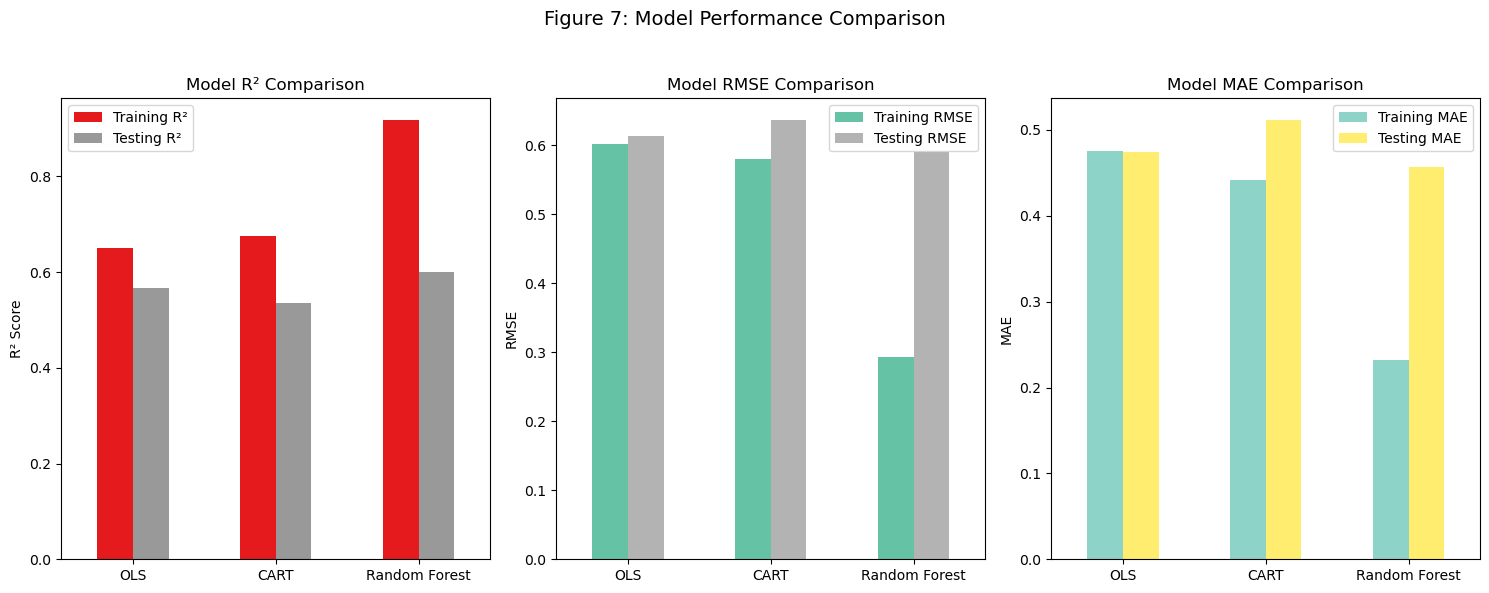

,Training R²,Testing R²,Training RMSE,Testing RMSE,Training MAE,Testing MAE
OLS,0.651381,0.567782,0.602136,0.613267,0.474992,0.474573
CART,0.676508,0.534580,0.580030,0.636385,0.441490,0.511137
Random Forest,0.917447,0.599828,0.293013,0.590093,0.232283,0.456595


In [27]:
compare_result(compare_results)

Feature importance from the Random Forest reveals that “Children_in_poverty” is the dominant predictor, followed by “Median_Household_income_log” and “Unemployed_log,” while other variables contribute little. Therefore, we focus our spatial clustering on these three key variables in addition to childhood obesity prevalence. This targeted variable selection improves cluster interpretability and provides valuable insights into the spatial patterns of social inequality affecting childhood obesity across London wards.

                                     Importance
Feature                                        
Children_in_poverty                    0.693077
Median_Household_income_log            0.098085
Unemployed_log                         0.094601
Unauthorised_Absence_in_All_Schools    0.052804
Crime_rate_log                         0.014318
Qualifications_Level4_and_above        0.010588
Households_with_access_to_openspace   -0.001313
People_with_Bad_or_Very_Bad_Health    -0.005060
Average_GCSE                          -0.012684


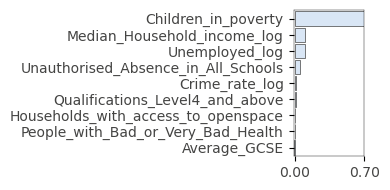

In [28]:
# as RF model shows the best prediction performance,
# we use the RF model to calculate the importances of each predictors
imp_rf = rfpimp.importances(rf_final, test_x, test_y)
print(imp_rf)
rfpimp.plot_importances(imp_rf).view()

Using the SKATER algorithm, we partitioned wards into three clusters(**Figure 7**). Cluster 1 (473 wards) represents high children in poverty rate, high unemployment, low household income and higher obesity prevalences. Cluster 0 (105 wards) comprises wards with better socioeconomic conditions and lower obesity, while Cluster 2 (35 wards) shows a mixed profile with intermediate obesity. 

In [34]:
# subset the key features for clustering from gdf_obesity_clean
attrs = ['Childhood_Obesity_Year6',
         'Children_in_poverty', 
         'Median_Household_income', 
         'Unemployed']
attributes = gdf_obesity_clean[attrs]

# define the number of clusters after trying 'n_clusters' value 
# from 2 to 4, we find that when the value is 3, 
# the silhouette score is the highest
n_clusters = 3

# build a SKATER clustering model
Skat = Skater(gdf_obesity_clean, w=w, n_clusters=n_clusters, attrs_name=attrs)
# solve the spatial clustering model
Skat.solve()

# add the cluster label column to the gdf
gdf_obesity_clean.loc[:, 'clusters'] = Skat.labels_

print(gdf_obesity_clean[['clusters']].value_counts())
# to estimate the quality of clustering results
print(f"The silhouette score is:{metrics.silhouette_score(attributes, Skat.labels_)}")

clusters
1           473
0           105
2            35
Name: count, dtype: int64
The silhouette score is:0.24239121462746716


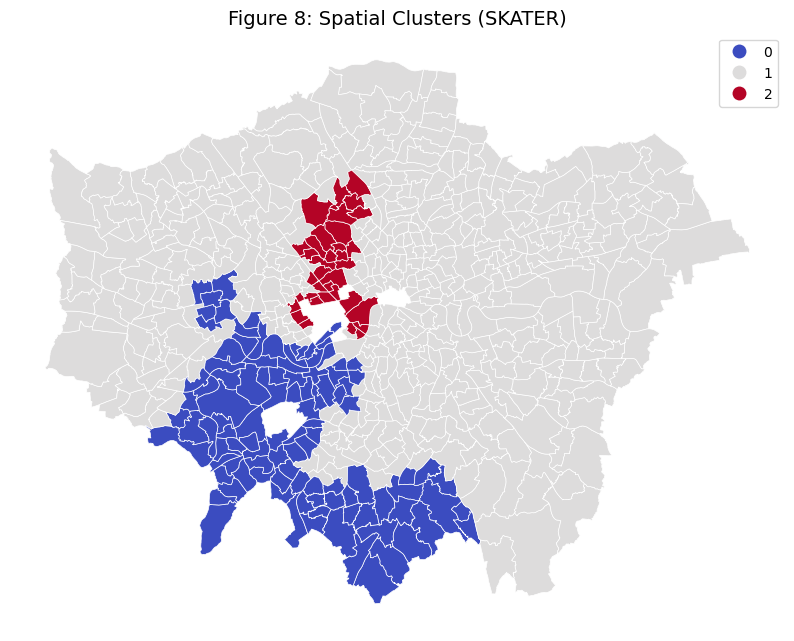

          Childhood_Obesity_Year6  Children_in_poverty  \
clusters                                                 
0                       16.954381            14.881619   
1                       22.659281            27.128605   
2                       20.157714            23.217143   

          Median_Household_income  Unemployed  
clusters                                       
0                    44956.571429    5.747431  
1                    36681.120507    9.652661  
2                    49116.571429    6.653094  


In [30]:
# define a function to show the plot and information of clusters
def cluster_plot():
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    gdf_obesity_clean.plot(edgecolor=(1, 1, 1, 1),linewidth=0.5, column='clusters', 
                          categorical=True, legend=True, cmap='coolwarm', ax=ax)
    ax.set_title("Figure 8: Spatial Clusters (SKATER)", fontsize=14)
    ax.axis('off')
    #plt.savefig("Spatial Clusters(SKATER).jpg", dpi=300, bbox_inches='tight')
    plt.show()

    # show the information of each clusters
    cluster_info = gdf_obesity_clean.groupby('clusters')[attrs].mean()
    print(cluster_info)

cluster_plot()

In [31]:
# the specific wards and their boroughs contained within each cluster
for cluster_label, group in gdf_obesity_clean.groupby('clusters'):
    ward_names = group['NAME'].unique()
    borough_names = group['BOROUGH'].unique()
    
    print("Cluster {} contains wards:".format(cluster_label))
    print(ward_names)
    print("\n")
    print("Cluster {} contains boroughs:".format(cluster_label))
    print(borough_names)
    print("\n\n")

Cluster 0 contains wards:
['Chessington South' 'Tolworth and Hook Rise' 'Berrylands' 'Alexandra'
 'Beverley' 'Coombe Hill' 'Chessington North and Hook' 'Surbiton Hill'
 'Old Malden' "St. Mark's" 'Grove' 'Canbury' 'Norbiton' 'Coombe Vale'
 'St. James' 'Tudor' 'Coulsdon East' 'Selsdon and Ballards'
 'Coulsdon West' 'Waddon' 'Kenley' 'Purley' 'Sanderstead' 'Heathfield'
 'Fairfield' 'New Addington' 'Croham' 'Fieldway' 'Shirley' 'Ashburton'
 'Addiscombe' 'Chiswick Homefields' 'Chiswick Riverside' 'Turnham Green'
 'Northfield' 'Walpole' 'Cleveland' 'Ealing Common' 'Ealing Broadway'
 'Southfield' 'Hanger Hill' 'Clapham Common' 'Clapham Town'
 'Carshalton South and Clockhouse' 'Cheam' 'Beddington South' 'Belmont'
 'Nonsuch' 'Worcester Park' 'Sutton South' 'Sutton West' 'Sutton Central'
 'Carshalton Central' 'Sutton North' 'Stonecot' 'The Wrythe'
 'Wallington South' 'Wallington North' 'Beddington North' 'Hampton'
 'Teddington' 'Hampton Wick' 'Twickenham Riverside'
 'Ham, Petersham and Richmond 

## Conclusion

[[ go back to the top ]](#Table-of-contents)

In conclusion, OLS exhibits robust, interpretable performance, while Random Forest yields marginal improvements. This suggests that the relationship is primarily linear, though non-linear methods capture subtle nuances.

To address spatial inequalities in childhood obesity, policymakers should tailor interventions by cluster: 
+ **Cluster 1** (high childhood obesity control area):
Provide free healthy meals in schools and community centers, raise public awareness of the consequences of obesity among parents and children, and expand safe and open spaces to encourage physical activity.
+ **Cluster 2** (mixed childhood obesity control area):
Investigate the dietary and activity patterns of children at the bottom of the ladder, enhance access to health and social services, and consider the redistribution of health resources within the region. 

## References

[[ go back to the top ]](#Table-of-contents)

Cutler, D.M. & Lleras-Muney, A., 2010. Understanding Differences in Health Behaviors by Education, Journal of health economics, 29(1), 1–28. https://doi.org/10.1016/j.jhealeco.2009.10.003

Goisis, A., Sacker, A. & Kelly, Y., 2016. Why are poorer children at higher risk of obesity and overweight? A UK cohort study, European Journal of Public Health, 26 (1). pp. 7-13. https://doi.org/10.1093/eurpub/ckv219

Gupta, N. et al., 2012. Childhood Obesity in Developing Countries: Epidemiology, Determinants, and Prevention, Endocrine Reviews. Oxford Academic, 33(1), 48–70. https://doi.org/10.1210/er.2010-0028

Sun, Y., Hu, X., Huang, Y., & On Chan, T., 2020. Spatial Patterns of Childhood Obesity Prevalence in Relation to Socioeconomic Factors across England. ISPRS International Journal of Geo-Information, 9(10), 599. https://doi.org/10.3390/ijgi9100599 

Wang, Y. & Lim, H., 2012. The global childhood obesity epidemic and the association between socio-economic status and childhood obesity, International Review of Psychiatry, 24(3), 176–188. https://doi.org/10.3109/09540261.2012.688195.

White, J., Rehkopf, D., & Mortensen, L. H., 2016. Trends in Socioeconomic Inequalities in Body Mass Index, Underweight and Obesity among English Children, 2007-2008 to 2011-2012, PloS One, 11(1), e0147614. https://doi.org/10.1371/journal.pone.0147614

World Health Organization, 2018. Taking Action on Childhood Obesity; World Health Organization: Geneva, Switzerland, 2018; pp. 1–7. https://iris.who.int/bitstream/handle/10665/274792/WHO-NMH-PND-ECHO-18.1-eng.pdf

Zhou, Y., Harris, R. & Tranos, E, 2023. Where Is the Geography? A Study of the Predictors of Obesity Using UK Biobank Data and Machine Learning. J geovis spat anal 7, 17(2023). https://doi.org/10.1007/s41651-023-00142-4


In [32]:
# %% [Runtime Report Cell]

def get_cpu_info():
    try:
        # Attempt Linux/WSL CPU info retrieval
        output = subprocess.check_output(
            'grep -m1 "model name" /proc/cpuinfo', 
            shell=True,
            stderr=subprocess.DEVNULL
        ).decode().strip()
        
        if 'model name' in output:
            # Extract GHz from string like "Intel(...) @ 2.40GHz"
            cpu_name = output.split(':')[1].strip()
            if '@' in cpu_name:
                ghz_part = cpu_name.split('@')[-1].replace('GHz', '').strip()
                return f"{ghz_part}GHz CPU", cpu_name
            return cpu_name.split('(')[0].strip(), cpu_name
    except (subprocess.CalledProcessError, FileNotFoundError):
        pass

    # Fallback 1: psutil detection
    try:
        if hasattr(psutil, "cpu_freq") and (freq := psutil.cpu_freq()):
            return f"{freq.max/1000:.2f}GHz CPU", "psutil-detected"
    except Exception:
        pass

    # Fallback 2: Manual specification
    return "1.80GHz CPU", "manual-default"  # Replace with your actual CPU speed

# Get kernel runtime
process = psutil.Process()
runtime_minutes = (time.time() - start_time) / 60

# Detect system specs
cpu_spec, cpu_source = get_cpu_info()

try:
    total_memory = psutil.virtual_memory().total / (1024**3)
    memory_spec = f"{total_memory:.1f}GB RAM"
except Exception:
    memory_spec = "8GB RAM"

print(f"Total runtime: {runtime_minutes:.1f} minutes\n"
      f"Hardware: {memory_spec}, {cpu_spec} ({cpu_source})\n"
      f"OS: {platform.system()} {platform.release()}")

Total runtime: 0.6 minutes
Hardware: 16.0GB RAM, 1.80GHz CPU (manual-default)
OS: Darwin 24.4.0
